# DCC Scrappy Implementation

#### Example 1: AAPL and S&P500


- GARCH estimator 
    - building all the bits and pieces one at a time
    - use regressed values to calculate actual forecasts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
# --- Data example df1 is AAPL and SPX daily returns for 5 years

raw_df1 = pd.read_csv("test_data/aapl_spx.csv")

df1 = raw_df1.copy()
df1_stats = df1.describe()
display(df1_stats)
print("Corrrelation: {:.4f}".format(df1.corr().iloc[0][1]))
static_OMEGA_X, static_OMEGA_A = df1_stats.loc["std"]**2
print("SPX omega  {}\nAAPL omega {}".format(static_OMEGA_X, static_OMEGA_A))

,spx,aapl
count,1258.000000,1258.000000
mean,0.037417,0.079348
std,0.853121,1.570995
min,-4.100000,-9.960000
25%,-0.300000,-0.627500
50%,0.050000,0.050000
75%,0.460000,0.890000
max,4.960000,7.040000


Corrrelation: 0.6732
SPX omega  0.7278148796627597
AAPL omega 2.468025509547172


#### Apply ARCH arch_model

In [48]:
# --- SPX
print("--------FIT ARCH ON SPX--------\n-------------------------------\n")
am_x = arch_model(df1.spx)
res_x = am_x.fit(update_freq=5)
display(res_x.summary())

print("--------FIT ARCH ON AAPL-------\n-------------------------------\n")
am_a = arch_model(df1.aapl)
res_a = am_a.fit(update_freq=5)
display(res_a.summary())

--------FIT ARCH ON SPX--------
-------------------------------

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1409.3357169508486
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1402.6825124009808
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1402.6824760983998
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    spx   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1402.68
Distribution:                  Normal   AIC:                           2813.36
Method:            Maximum Likelihood   BIC:                           2833.91
                                        No. Observations:                 1258
Date:                Tue, May 03 2022   Df Residuals:                     1257
Time:                        10:49:23   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0806  1.827e-02      4.410  1.035e-05 [4.476e-02,  0.116]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0422  1.331e-02      3.171  1.520e-03 [1.612e-02,6.828e-02]
alpha[1]       0.2068  4.255e-02      4.861  1.168e-06     [  0.123,  0.290]
beta[1]        0.7428  4.037e-02     18.401  1.301e-75     [  0.664,  0.822]
============================================================================

Covariance estimator: robust
"""

--------FIT ARCH ON AAPL-------
-------------------------------

Iteration:      5,   Func. Count:     35,   Neg. LLF: 2290.659392676643
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2289.2040753904357
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   aapl   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2289.20
Distribution:                  Normal   AIC:                           4586.41
Method:            Maximum Likelihood   BIC:                           4606.96
                                        No. Observations:                 1258
Date:                Tue, May 03 2022   Df Residuals:                     1257
Time:                        10:49:23   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1544  4.225e-02      3.655  2.568e-04 [7.163e-02,  0.237]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1995  7.024e-02      2.841  4.501e-03 [6.187e-02,  0.337]
alpha[1]       0.1228  3.233e-02      3.797  1.464e-04 [5.939e-02,  0.186]
beta[1]        0.8007  4.334e-02     18.474  3.356e-76   [  0.716,  0.886]
==========================================================================

Covariance estimator: robust
"""

In [4]:
res_x.params
MU_X, OMEGA_X, ALPHA_X, BETA_X = res_x.params
MU_A, OMEGA_A, ALPHA_A, BETA_A = res_a.params

In [5]:
# --- DCC Parameters for df1 - Using _X for SPX, _A for AAPL

MU_X, MU_A = df1_stats.loc['mean']
AB_X, AB_A = ALPHA_X + BETA_X, ALPHA_A + BETA_A # alpha + beta
if AB_X > 1 or AB_A > 1: print("SUMS WRONG BRO")
LR_VOL_X, LR_VOL_A = MU_X / (1 - AB_X), MU_A / (1 - AB_A) # long run volatility
INITIAL_CORRELATION = df1.corr().iloc[0][1]

In [18]:
# --- Residuals = return - mu (constant mean)

df1["spx_resids"], df1["aapl_resids"] = df1.spx - MU_X, df1.aapl - MU_A
df1["spx_resids_sq"], df1["aapl_resids_sq"] = df1.spx_resids**2, df1.aapl_resids**2
df1["spx_resids_sq_lag"] = df1.spx_resids_sq.shift(1)
df1["aapl_resids_sq_lag"] = df1.aapl_resids_sq.shift(1)

df1["spx_conditional_var"] = pd.Series(index=df1.index, dtype="float64")
df1.loc[(0, "spx_conditional_var")] = LR_VOL_X
df1["aapl_conditional_var"] = pd.Series(index=df1.index, dtype="float64")
df1.loc[(0, "aapl_conditional_var")] = LR_VOL_A

In [19]:
df1.head()

,date,spx,aapl,spx_resids,aapl_resids,spx_resids_sq,aapl_resids_sq,spx_resids_sq_lag,aapl_resids_sq_lag,spx_conditional_var,aapl_conditional_var
0,12/2/2014,0.64,-0.38,0.602583,-0.459348,0.363107,0.211001,NaN,NaN,0.743308,1.036696
1,12/3/2014,0.38,1.13,0.342583,1.050652,0.117363,1.103869,0.363107,0.211001,NaN,NaN
2,12/4/2014,-0.12,-0.38,-0.157417,-0.459348,0.024780,0.211001,0.117363,1.103869,NaN,NaN
3,12/5/2014,0.17,-0.42,0.132583,-0.499348,0.017578,0.249349,0.024780,0.211001,NaN,NaN
4,12/8/2014,-0.73,-2.26,-0.767417,-2.339348,0.588928,5.472550,0.017578,0.249349,NaN,NaN


Conditional variance given by:
$$
\nu_t^2 =\omega + \alpha \epsilon_{t-1}^2 + \beta \nu_{t-1}^2
$$

In [27]:
# --- Implement formula

for i, row in df1.iloc[1:].iterrows():
    prev_resid_sq_x = row.spx_resids_sq_lag
    prev_cond_vol_x = df1.loc[(i-1, "spx_conditional_var")]
    prev_resid_sq_a = row.aapl_resids_sq_lag
    prev_cond_vol_a = df1.loc[(i-1, "aapl_conditional_var")]

    df1.loc[(i, "spx_conditional_var")] = OMEGA_X+ALPHA_X*prev_resid_sq_x+BETA_X*prev_cond_vol_x
    df1.loc[(i, "aapl_conditional_var")] = OMEGA_A+ALPHA_A*prev_resid_sq_a+BETA_A*prev_cond_vol_a

In [29]:
# --- Realised vs GARCH volatility
df1["realised_volatility_x"] = np.sqrt(df1.spx_resids_sq)
df1["realised_volatility_a"] = np.sqrt(df1.aapl_resids_sq)
df1["GARCH_volatility_x"] = np.sqrt(df1.spx_conditional_var)
df1["GARCH_volatility_a"] = np.sqrt(df1.aapl_conditional_var)

In [30]:
df1.head()

,date,spx,aapl,spx_resids,aapl_resids,spx_resids_sq,aapl_resids_sq,spx_resids_sq_lag,aapl_resids_sq_lag,spx_conditional_var,aapl_conditional_var,realised_volatility_x,realised_volatility_a,GARCH_volatility_x,GARCH_volatility_a
0,12/2/2014,0.64,-0.38,0.602583,-0.459348,0.363107,0.211001,NaN,NaN,0.743308,1.036696,0.602583,0.459348,0.862153,1.018183
1,12/3/2014,0.38,1.13,0.342583,1.050652,0.117363,1.103869,0.363107,0.211001,0.669455,1.055525,0.342583,1.050652,0.818202,1.027387
2,12/4/2014,-0.12,-0.38,-0.157417,-0.459348,0.024780,0.211001,0.117363,1.103869,0.563767,1.180211,0.157417,0.459348,0.750844,1.086375
3,12/5/2014,0.17,-0.42,0.132583,-0.499348,0.017578,0.249349,0.024780,0.211001,0.466110,1.170437,0.132583,0.499348,0.682723,1.081867
4,12/8/2014,-0.73,-2.26,-0.767417,-2.339348,0.588928,5.472550,0.017578,0.249349,0.392078,1.167319,0.767417,2.339348,0.626161,1.080425


<AxesSubplot:>

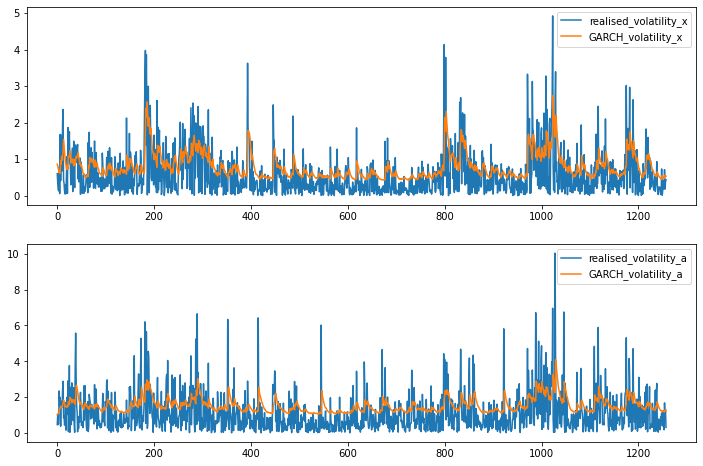

In [49]:
_, ax = plt.subplots(2, 1, figsize=(12, 8))
df1[["realised_volatility_x", "GARCH_volatility_x"]].plot(ax=ax[0])
df1[["realised_volatility_a", "GARCH_volatility_a"]].plot(ax=ax[1])

#### Goodness of GARCH fit
test options:
1. Are errors iid?
2. Do an ACF
3. Ljung Box test
4. Turning point test
5. Differnece sign test
6. QQ Plot

In [97]:
# --- 1. Error plot

iid_check = df1.copy()[["date", "realised_volatility_a", "realised_volatility_x", 
                 "GARCH_volatility_a", "GARCH_volatility_x"]]
error_x = iid_check.realised_volatility_x - iid_check.GARCH_volatility_x
error_x = (error_x - error_x.mean())/ error_x.std()
error_a = iid_check.realised_volatility_a - iid_check.GARCH_volatility_a
error_a = (error_a - error_a.mean()) / error_a.std()
iid_check["error_x"] = error_x
iid_check["error_a"] = error_a

<AxesSubplot:xlabel='error_x'>

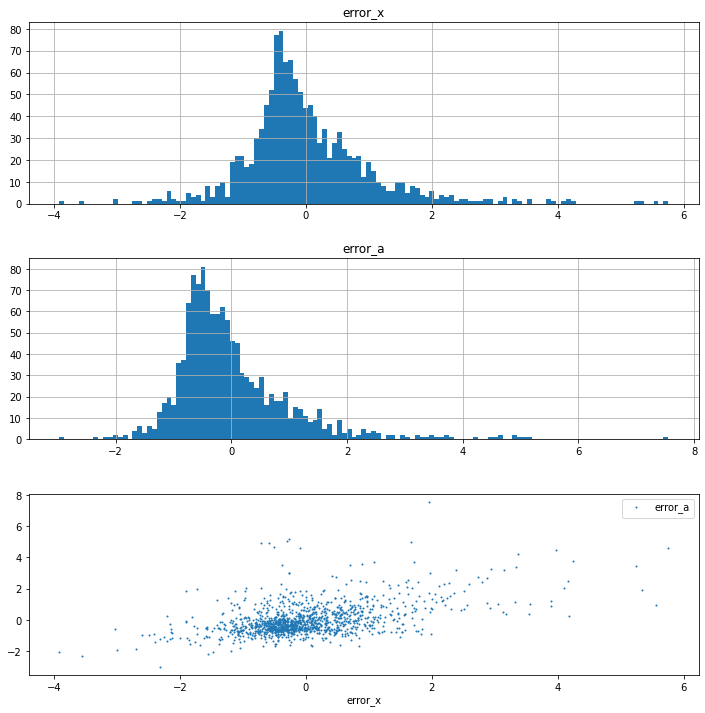

In [101]:
_, ax = plt.subplots(3, 1, figsize=(12, 12))

# iid_check.plot(x="date", y="error_x", lw=1, ax=ax[0])
# iid_check.plot(x="date", y = "error_a", lw=1, ax=ax[1])
n_bins = len(iid_check)//10
iid_check.hist("error_x", bins=n_bins, ax=ax[0])
iid_check.hist("error_a", bins=n_bins, ax=ax[1])

iid_check.plot(x="error_x", y="error_a", lw=0, marker='.', ms=2, ax=ax[2])


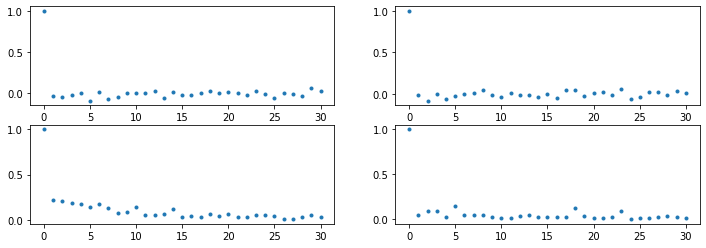

In [137]:
from statsmodels.tsa.stattools import acf

_, axes = plt.subplots(2, 2, figsize=(12, 4))
ax = axes.flatten()
acf_x, acf_a, = acf(iid_check.error_x), acf(iid_check.error_a)
acf_x_2, acf_a_2, = acf(iid_check.error_x**2), acf(iid_check.error_a**2)
ax[0].plot(range(len(acf_x)), acf_x, '.'), ax[1].plot(range(len(acf_a)), acf_a, '.');
ax[2].plot(range(len(acf_x)), acf_x_2, '.'), ax[3].plot(range(len(acf_a)), acf_a_2, '.');

#### DCC Components

Dynamic a and Dynamic b are applied to the matrix of prices

$$
Q_t = (1 - a - b)\bar Q + a \epsilon_{t-1} \epsilon_{t-1}^T + b Q_{t-1}
$$

- Get $Q_t$
- $Q_t^* = diag(Q_t^{\frac{1}{2}})$ 
- $R_t = Q_t^* Q_t Q_t^*$
- $D_t = diag(\nu_t)$
- $H_t = D_t R_t D_t$


c = starting correlation
$$
\bar Q = 
\begin{bmatrix}
\omega_x^2 & \omega_x  \omega_a  c\\
\omega_x  \omega_a  c & \omega_a^2 \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
\omega_x^2 & \omega_x  \omega_a  c\\
\omega_x  \omega_a  c & \omega_a^2 \\
\end{bmatrix}
$$

In [143]:
# --- Constants

array([[ 5.08744038e-04, -3.02066773e-04],
       [ 1.93322734e-04, -3.41335453e-04],
       [-2.31987281e-05,  1.29707472e-04],
       ...,
       [-0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00]])

In [ ]:
dynamic_a, dynamic_b = 0, 0
